In [127]:
import numpy as np
import matplotlib.pyplot as plt

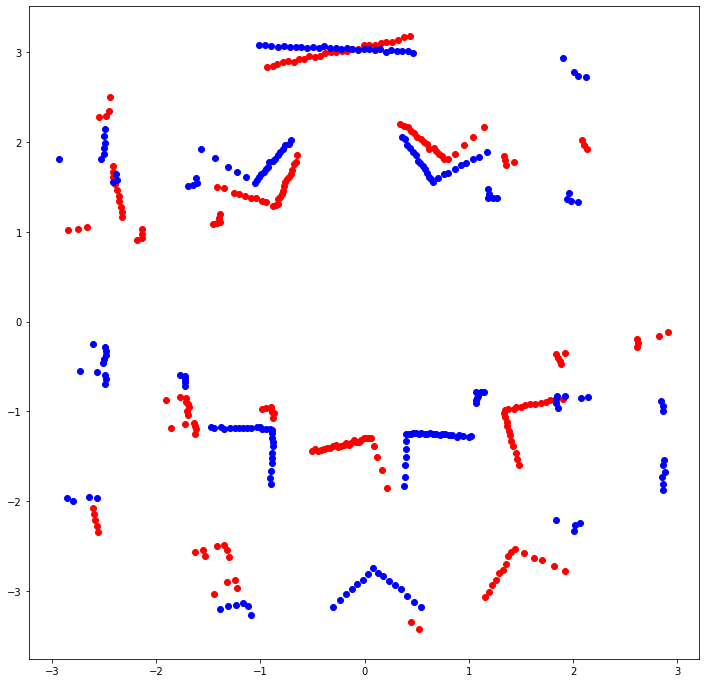

In [735]:
x = np.load("../../../scan_0.npy")
y = np.load("../../../scan_25.npy")

x_org = x
y_org = y

fig = plt.figure(figsize=(12,12))
plt.scatter(x[:,0], x[:,1], c = 'r')
plt.scatter(y[:,0], y[:,1], c = 'b')
plt.show()

In [406]:
def transform(x: np.ndarray, R: np.ndarray, t: np.ndarray) -> np.ndarray:
    """ rotate and move a vector, not sure transform is the right word """
    assert R.shape == (3,3) and t.shape == (3,) and x.shape[1] == 3, "Wrong shapes"
    return (R @ x.T + t[:, None]).T

In [167]:
from sklearn.neighbors import NearestNeighbors

max_iters = 100

R = np.eye(3)
t = np.zeros(3)
distance_threshold = 1.0 # should ideally not be a parameter, makes it hard to tune
tolerance = 0.2  # idk a good value

nbrs = NearestNeighbors(n_neighbors=1, algorithm='kd_tree').fit(y)

distances, indices = nbrs.kneighbors(transform(x,R,t))
print(x.shape)
print(y.shape)
print(distances.shape)
print(indices.shape)

(220, 3)
(218, 3)
(220, 1)
(220, 1)


In [132]:
# from collections import defaultdict

# closest = {}

# # indices: for every point in x get the index of the closest point in y
# distances, indices = nbrs.kneighbors(transform(x,R,t))

# x_new = np.zeros_like(y)

# for p, i in zip(x, indices.ravel()):
#     # the closest dist to y index
#     dist = np.linalg.norm(p - y[i])
    
#     if not (i in closest):
#         closest[i] = dist
#         x_new[i] = p
#     elif dist < closest[i]:
#         closest[i] = dist
#         x_new[i] = p

In [135]:
# mask = ~(x_new == 0).all(axis= 1)

# x_new = x_new[mask]
# y_new = y[mask]

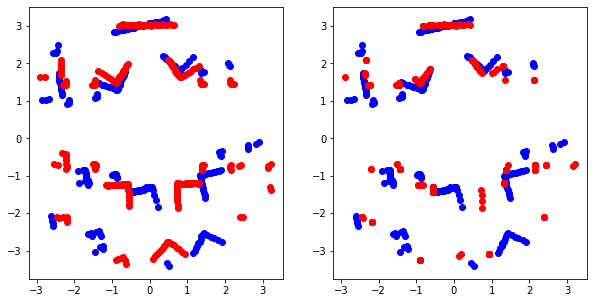

In [172]:

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

axs[0].scatter(x[:,0], x[:,1], c = 'b')
axs[0].scatter(y[:,0], y[:,1], c = 'r')

y_hat = y[indices].squeeze()

# for i in range(len(x)):
#     axs[1].plot([x[i, 0], y_hat[i, 0]], [x[i, 1], y_hat[i, 1]], 'k--')

axs[1].scatter(x[:,0], x[:,1], c = 'b')
axs[1].scatter(y_hat[:,0], y_hat[:,1], c = 'r')

plt.show()

In [663]:
def weighted_average(values: np.ndarray, weights: np.ndarray = None) -> np.ndarray:
    """ Get the centre of mass for a set of values, """
    assert weights is None or values.shape[0] == weights.shape[0]
    return np.average(values, weights=weights, axis=0)

def compute_transformation_params(x: np.ndarray, y: np.ndarray, p: np.ndarray = None) -> tuple[np.ndarray, np.ndarray]:
    """
    Perform a single step of ICP where perfect corresponence is assumed. 
    Returns a rotation matrix and translation vector.
    """
    assert x.shape == y.shape
    if p is None:
        p = np.ones(len(x))
    # Get the centres of mass
    x_0 = weighted_average(x, p)
    y_0 = weighted_average(y, p)

    # Calculate cross covariance matrix
    H = (y_0 - y).T @ ((x_0 - x) * p[:, None])

    # Do SVD
    U, _S, Vt = np.linalg.svd(H)    

    # Calculate rotation matrix and translation vector
    R = U @ Vt # Vh.T @ U.T # 
    t = y_0 - R @ x_0

    return R, t



In [685]:
R = np.eye(3)
t = np.zeros(3)

nbrs = NearestNeighbors(n_neighbors=1, algorithm='kd_tree').fit(y_org)

x = x_org
y = y_org

prev_indices = None


0.6356477699331677
(211, 1) (211, 1)
True


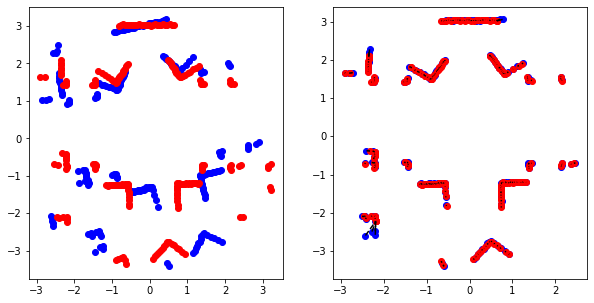

In [715]:
# TODO
# - threshold exit
# - outlier rejection
# - speed (?)
# - error / matching measure 

# x = x_org
x = transform(x_org,R,t)

distances, indices = nbrs.kneighbors(x)

inlier_indices = (distances < np.mean(distances) + 2 * np.std(distances)).ravel()
indices = indices[inlier_indices]

x = x[inlier_indices]

y_hat = y_org[indices].squeeze()

R_, t_ = compute_transformation_params(x, y_hat)

R = R @ R_
t = t + t_

ssd = np.sum((x - y_hat)**2)
print(ssd)

if (not prev_indices is None) and (indices.shape == prev_indices.shape):
    print(prev_indices.shape, indices.shape)
    print((indices == prev_indices).all())

# print(indices)
prev_indices = indices


fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

axs[0].scatter(x_org[:,0], x_org[:,1], c = 'b')
axs[0].scatter(y_org[:,0], y_org[:,1], c = 'r')

for i in range(len(x)):
    axs[1].plot([x[i, 0], y_hat[i, 0]], [x[i, 1], y_hat[i, 1]], 'k--')

axs[1].scatter(x[:,0], x[:,1], c = 'b')
axs[1].scatter(y_hat[:,0], y_hat[:,1], c = 'r')


plt.show()

ICP error @ iteration 1: 26.147
ICP error @ iteration 2: 24.852
ICP error @ iteration 3: 23.183
ICP error @ iteration 4: 23.011
ICP error @ iteration 5: 23.453
ICP error @ iteration 6: 23.354
ICP error @ iteration 7: 22.231
ICP error @ iteration 8: 21.995
ICP error @ iteration 9: 22.236
ICP error @ iteration 10: 22.874
ICP error @ iteration 11: 22.101
ICP error @ iteration 12: 20.162
ICP error @ iteration 13: 17.988
ICP error @ iteration 14: 16.292
ICP error @ iteration 15: 13.592
ICP error @ iteration 16: 7.981
ICP error @ iteration 17: 4.151
ICP error @ iteration 18: 1.654
ICP error @ iteration 19: 0.761
ICP error @ iteration 20: 0.859
ICP error @ iteration 21: 0.719
ICP error @ iteration 22: 0.675
ICP error @ iteration 23: 0.666
ICP error @ iteration 24: 0.664
ICP error @ iteration 25: 0.881
ICP error @ iteration 26: 0.879
ICP error @ iteration 27: 0.878
ICP error @ iteration 28: 0.878
ICP error @ iteration 29: 0.877
ICP error @ iteration 30: 0.877
ICP error @ iteration 31: 0.877


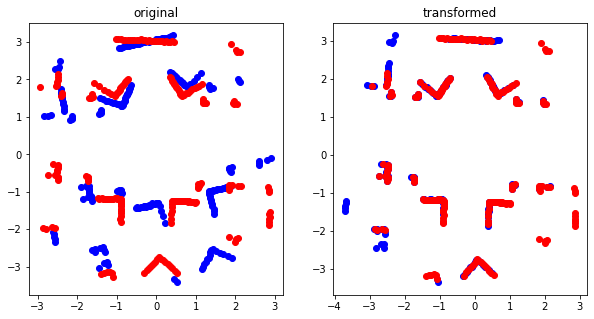

In [742]:
R = np.eye(3)
t = np.zeros(3)
verbose = True
nbrs = NearestNeighbors(n_neighbors=1, algorithm='kd_tree').fit(y_org)

x = x_org
y = y_org

n_iter = 100

prev_indices = None

for i in range(n_iter):
    
    x = transform(x_org, R, t)

    # Get matching
    distances, indices = nbrs.kneighbors(x)
    distances = distances.ravel()
    indices = indices.ravel()

    # Find outliers
    inlier_indices = distances < np.mean(distances) + 2 * np.std(distances)
    indices = indices[inlier_indices]

    # Remove outliers
    x = x[inlier_indices]
    y_hat = y_org[indices]

    # Fit points
    R_, t_ = compute_transformation_params(x, y_hat)
    R = R @ R_
    t = t + t_

    if verbose:
        ssd = np.sum((x - y_hat)**2)
        print(f"ICP error @ iteration {i + 1}: {ssd:.3f}")


    # If nothing is changed, we break
    if np.array_equal(indices, prev_indices):
        break

    prev_indices = indices


fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

axs[0].set_title("original")
axs[0].scatter(x_org[:,0], x_org[:,1], c = 'b')
axs[0].scatter(y_org[:,0], y_org[:,1], c = 'r')

axs[1].set_title("transformed")
axs[1].scatter(transform(x_org,R,t)[:,0], transform(x_org,R,t)[:,1], c = 'b')
axs[1].scatter(y_org[:,0], y_org[:,1], c = 'r')

plt.show()

In [759]:
def ICP(x: np.ndarray, y: np.ndarray, max_iters: int = 100, verbose: bool = False) -> tuple[np.ndarray, np.ndarray]:
    """ Does vanilla point-to-point ICP. Not KISS-ICP, too hard tbh """
    R = np.eye(3)
    t = np.zeros(3)
    prev_indices = None

    nbrs = NearestNeighbors(n_neighbors=1, algorithm='kd_tree').fit(y)

    for i in range(max_iters):

        x_hat = transform(x, R, t)

        # Get matching
        distances, indices = nbrs.kneighbors(x_hat)
        distances = distances.ravel()
        indices = indices.ravel()

        # Find outliers
        inlier_indices = distances < np.mean(distances) + 2 * np.std(distances)
        indices = indices[inlier_indices]

        # Remove outliers
        x_hat = x_hat[inlier_indices]
        y_hat = y[indices]

        # Fit points
        R_delta, t_delta = compute_transformation_params(x_hat, y_hat)
        R = R @ R_delta
        t = t + t_delta

        if verbose:
            mse = np.mean((x_hat - y_hat)**2)
            print(f"ICP error @ iteration {i + 1}: {mse:.5f} | n points {len(x_hat)}")


        # If nothing is changed, we break
        if np.array_equal(indices, prev_indices):
            break

        prev_indices = indices

    return R, t

In [760]:
ICP(x_org, y_org, verbose=True)

ICP error @ iteration 1: 0.04092 | n points 213
ICP error @ iteration 2: 0.03926 | n points 211
ICP error @ iteration 3: 0.03715 | n points 208
ICP error @ iteration 4: 0.03688 | n points 208
ICP error @ iteration 5: 0.03740 | n points 209
ICP error @ iteration 6: 0.03725 | n points 209
ICP error @ iteration 7: 0.03580 | n points 207
ICP error @ iteration 8: 0.03542 | n points 207
ICP error @ iteration 9: 0.03563 | n points 208
ICP error @ iteration 10: 0.03631 | n points 210
ICP error @ iteration 11: 0.03508 | n points 210
ICP error @ iteration 12: 0.03231 | n points 208
ICP error @ iteration 13: 0.02883 | n points 208
ICP error @ iteration 14: 0.02598 | n points 209
ICP error @ iteration 15: 0.02147 | n points 211
ICP error @ iteration 16: 0.01285 | n points 207
ICP error @ iteration 17: 0.00668 | n points 207
ICP error @ iteration 18: 0.00266 | n points 207
ICP error @ iteration 19: 0.00123 | n points 207
ICP error @ iteration 20: 0.00137 | n points 209
ICP error @ iteration 21: 0.0

(array([[ 0.96180223,  0.27374526,  0.        ],
        [-0.27374526,  0.96180223,  0.        ],
        [ 0.        ,  0.        ,  1.        ]]),
 array([-0.60421299,  0.0751579 ,  0.        ]))

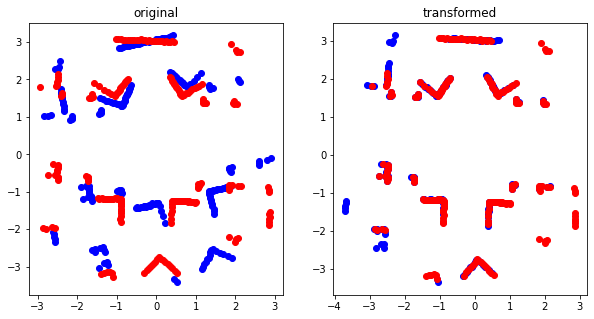

In [751]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

axs[0].set_title("original")
axs[0].scatter(x_org[:,0], x_org[:,1], c = 'b')
axs[0].scatter(y_org[:,0], y_org[:,1], c = 'r')

axs[1].set_title("transformed")
axs[1].scatter(transform(x_org,R,t)[:,0], transform(x_org,R,t)[:,1], c = 'b')
axs[1].scatter(y_org[:,0], y_org[:,1], c = 'r')

plt.show()